In [7]:
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import pydicom 
import cv2 

"""Read in DICOM images conert to numpy arrays
(c) Karl Diedrich 2018 <ktdiedrich@gmail.com>
"""

def read_DICOM(dir_path):
    'Read DICOM image from directory'
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( dir_path )   
    if len(dicom_names) > 0:
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image
    else:
        return None

def get_slice(im, axis=1, fract=0.5, flip=None):
    'Show slice along axis at fraction of slice'
    if isinstance(im, sitk.SimpleITK.Image):
        im = sitk.GetArrayFromImage(im)
    if flip != None:
        im = np.flip(im, flip)
    idx = int(im.shape[axis]*fract)
    if axis == 0:
        im_slice = im[idx, :, :]
    elif axis == 1:
        im_slice = im[:, idx, :]
    elif axis == 2:
        im_slice = im[:, :, idx]
    else:
        im_slice = im[idx, :, :]
    return im_slice
    
images_dir_path = ('/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/LIDC-IDRI')
dir_path_1 = os.path.join(images_dir_path, 'LIDC-IDRI-0001/01-01-2000-30178/')
slices_dir = '/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/slice_images/1'
print(images_dir_path)
print(dir_path_1)
if not os.path.exists(slices_dir):
    os.makedirs(slices_dir)

/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/LIDC-IDRI
/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/


Images 992 median (X 209, Y 512, Z 3)


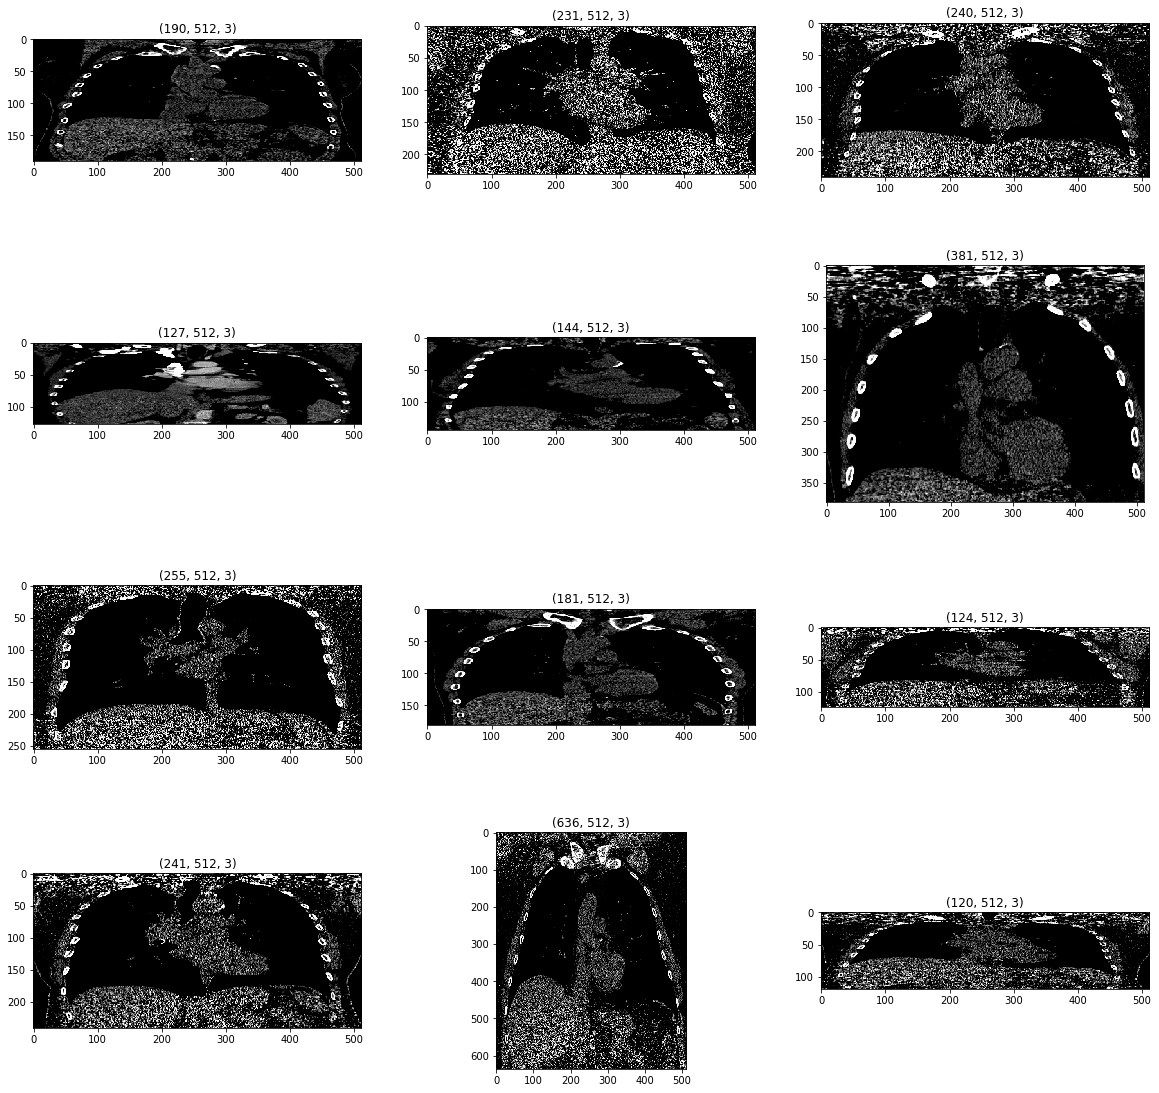

In [8]:
slice_fnames = [fi for fi in os.listdir(slices_dir) if fi.endswith(".png")]
slice_images = list()
if len(slice_fnames) > 0:
    dim_x=list()
    dim_y=list()
    dim_z=list()
    for fname in slice_fnames:
        fpath = os.path.join(slices_dir, fname)
        slice_img = cv2.imread(fpath, cv2.COLOR_RGB2GRAY)
        if slice_img.shape[0] > 5 and slice_img.shape[1] > 5:
            slice_images.append(slice_img)
            dim_x.append(slice_img.shape[0])
            dim_y.append(slice_img.shape[1])
            dim_z.append(slice_img.shape[2])
    slice_len = len(slice_images)
    dim_x = int(np.median(dim_x))
    dim_y = int(np.median(dim_y))
    dim_z = int(np.median(dim_z))
    print("Images {} median (X {}, Y {}, Z {})".format(len(slice_images), dim_x, dim_y, dim_z))
    plt.figure(figsize=(20, 20))
    for idx in range(0, 12):
        plt.subplot(4, 3, idx+1)
        img = slice_images[idx]
        plt.imshow(img, cmap='gray')
        plt.title(img.shape)
    

In [11]:
resized_images = list()
for img in slice_images:
    rez_img = cv2.resize(img, (dim_y, dim_x))
    resized_images.append(rez_img[:,:,0])
print("Images: {}".format(len(resized_images)))
print("{} -> {}".format(slice_images[33].shape, resized_images[33].shape))

Images: 992
(445, 512, 3) -> (209, 512)


In [10]:
reshaped_vector = np.array(resized_images)
print(reshaped_vector.shape)

(992, 209, 512)


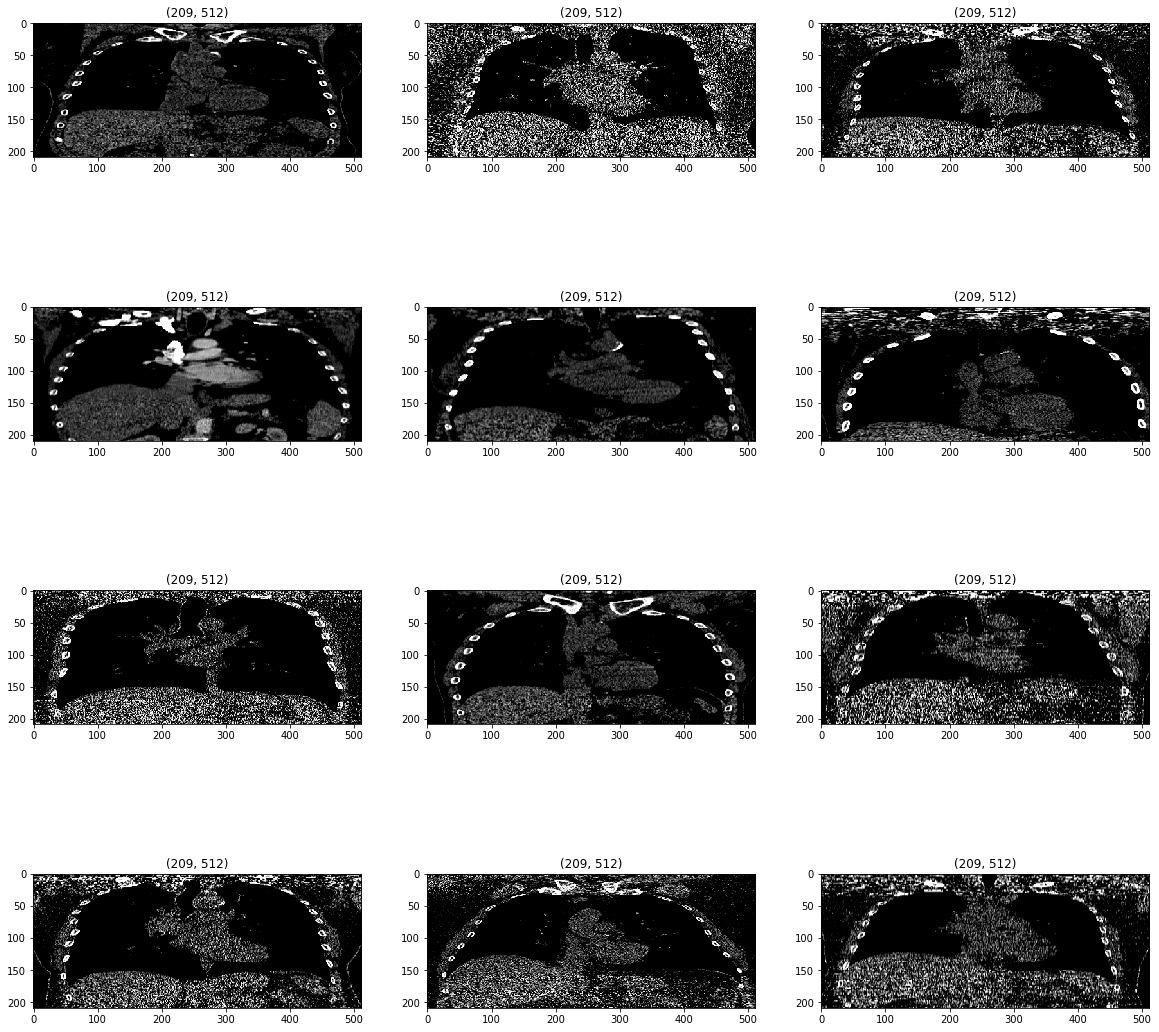

In [12]:
plt.figure(figsize=(20,20))
for idx in range(0, 12):
    plt.subplot(4, 3, idx+1)
    img = resized_images[idx]
    plt.imshow(img, cmap='gray')
    plt.title(img.shape)

In [15]:
img_shape = reshaped_vector[0].shape
print("image shape {}".format(img_shape))
# img_shape = (28, 28, 1)

image shape (209, 512)


In [16]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


print("shape {}".format(img_shape))
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

shape (209, 512)


ValueError: Input 0 is incompatible with layer conv2d_2: expected ndim=4, found ndim=3

In [45]:
   
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])



In [46]:
print("shape before flattening {}".format(shape_before_flattening))
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

print("x type {}".format(type(x) ))

shape before flattening (None, 110, 256, 64)
x type <class 'tensorflow.python.framework.ops.Tensor'>


In [47]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [50]:
image_n = reshaped_vector.shape[0]
reshaped_vector = np.reshape(reshaped_vector, reshaped_vector.shape[0:3])
print(reshaped_vector.shape)
print(image_n)
train_n = int(image_n *.8)
print(train_n)
print(reshaped_vector[0:train_n].shape)
print(reshaped_vector[train_n:].shape)

(876, 220, 512)
876
700
(700, 220, 512)
(176, 220, 512)


In [51]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)


# Train the VAE on MNIST digits
#(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = reshaped_vector[0:train_n]
x_test = reshaped_vector[train_n:]
print(x_train.shape)
print(x_test.shape)
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))



(700, 220, 512)
(176, 220, 512)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.
  after removing the cwd from sys.path.


In [52]:
print(vae.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 220, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 220, 512, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 110, 256, 64) 18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 110, 256, 64) 36928       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

In [53]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 700 samples, validate on 176 samples
Epoch 1/10
700/700 [==============================] - 13s 19ms/step - loss: nan - val_loss: nan
Epoch 2/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 3/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 4/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 5/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 6/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 7/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 8/10
700/700 [==============================] - 11s 16ms/step - loss: nan - val_loss: nan
Epoch 9/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_loss: nan
Epoch 10/10
700/700 [==============================] - 11s 15ms/step - loss: nan - val_los

In [54]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

ValueError: cannot reshape array of size 112640 into shape (28,28)

In [56]:
x_train[0].shape
220*512

112640